In [1]:
!python -m pip install resampy

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3.1/3.1 MB 38.7 MB/s eta 0:00:00


# Import n√©cessaire

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import glob

ImportError: Traceback (most recent call last):
  File "c:\Users\anase\Documents\Master\analyse de donn√©e IA\birdsong-app\.venv\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Une routine d‚Äôinitialisation d‚Äôune biblioth√®que de liens dynamiques (DLL) a √©chou√©.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

# 2 Configuration des chemins Drive

In [1]:

AUDIO_DIR = '/dataset/bird_audio'
SAMPLE_RATE = 22050
DURATION = 5
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Define the path to your CSV files within Google Drive
CSV_DIR = '/dataset/'

# 3 Lire les fichiers CSV avec les chemins dynamique

In [9]:
print(os.path.join('./dataset/train_metadata_reduced.csv'))
metadata = pd.read_csv(os.path.join('./dataset/train_metadata_reduced.csv'))
taxonomy = pd.read_csv(os.path.join('./dataset/eBird_Taxonomy_v2021_reduced.csv'))

metadata['filepath'] = metadata.apply(lambda row: os.path.join(AUDIO_DIR, row['primary_label'], row['filename']), axis=1)


./dataset/train_metadata_reduced.csv


# √âtape 4 : Mettre √† jour les fichiers CSV avec les informations du nouveau dataset.



In [6]:
NEW_DATASET_DIR = AUDIO_DIR

# Parcourir tous les fichiers du nouveau dataset
for bird_class in os.listdir(NEW_DATASET_DIR):
    class_dir = os.path.join(NEW_DATASET_DIR, bird_class)

    # V√©rifier si le r√©pertoire courant est un dossier
    if os.path.isdir(class_dir):
        for audio_file in os.listdir(class_dir):
            if audio_file.endswith('.ogg'): # Assurez-vous que vous ne traitez que les fichiers audio
                # Extraire les informations du fichier audio
                filename = audio_file
                primary_label = bird_class

                # Cr√©er une nouvelle ligne pour le DataFrame metadata
                new_row = pd.DataFrame({'primary_label': [primary_label], 'filename': [filename]})

                # Ajouter la nouvelle ligne au DataFrame metadata
                metadata = pd.concat([metadata, new_row], ignore_index=True)

metadata.to_csv(os.path.join(CSV_DIR, 'train_metadata_reduced.csv'), index=False)
# Si vous avez √©galement mis √† jour taxonomy, sauvegardez-le √©galement
taxonomy.to_csv(os.path.join(CSV_DIR, 'eBird_Taxonomy_v2021_reduced.csv'), index=False)




# 4 Affichage du debuggage / Filtrage

In [7]:
# Print the number of files found before filtering
print(f"Number of files found: {len(metadata)}")

# Print the first 5 filepaths to check if they are correct
print(metadata.head())

# Filter the metadata DataFrame *before* creating the 'filepath' column
metadata = metadata[metadata.apply(lambda row: os.path.exists(os.path.join(AUDIO_DIR, row['primary_label'], row['filename'])), axis=1)]


Number of files found: 24033
  primary_label secondary_labels              type  latitude  longitude  \
0       abethr1               []          ['song']    4.3906    38.2788   
1       abethr1               []          ['call']   -2.9524    38.2921   
2       abethr1               []          ['song']   -2.9524    38.2921   
3       abethr1               []          ['song']   -2.9524    38.2921   
4       abethr1               []  ['call', 'song']   -2.9524    38.2921   

      scientific_name               common_name         author  \
0  Turdus tephronotus  African Bare-eyed Thrush  Rolf A. de By   
1  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
2  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
3  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   
4  Turdus tephronotus  African Bare-eyed Thrush  James Bradley   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     4.

# 5  Fonctions utilitaires pour la conversion audio

In [8]:
def load_audio(file_path, sr=SAMPLE_RATE, duration=DURATION):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, sr * duration - len(audio)))
    return audio

def extract_mel_spectrogram(audio, sr=SAMPLE_RATE):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def augment_audio(audio):
    if random.random() < 0.3:
        audio = audio + 0.005 * np.random.randn(len(audio))
    if random.random() < 0.3:
        audio = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=random.choice([-2, -1, 1, 2]))
    if random.random() < 0.3:
        rate = random.uniform(0.8, 1.2)
        # Adjust the call to time_stretch to use the 'rate' keyword argument within a dictionary.
        audio = librosa.effects.time_stretch(audio, rate=rate)
    return audio


SPEC_DIR = '/content/drive/MyDrive/dataset/spectrograms'


# 6 Pr√©paration des spectrogrammes

In [9]:
def prepare_spectrograms():
    os.makedirs(SPEC_DIR, exist_ok=True)

    for bird_class in os.listdir(AUDIO_DIR):
        class_dir = os.path.join(AUDIO_DIR, bird_class)
        output_class_dir = os.path.join(SPEC_DIR, bird_class)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        if os.path.isdir(class_dir):
            print(f"Processing {bird_class}...")
            for audio_file in os.listdir(class_dir):
                if audio_file.endswith('.ogg'):
                    audio_path = os.path.join(class_dir, audio_file)
                    spec_path = os.path.join(output_class_dir, audio_file.replace('.ogg', '.png'))

                    if not os.path.exists(spec_path):
                        # Charger et augmenter l'audio
                        audio = load_audio(audio_path)
                        audio = augment_audio(audio)

                        # Cr√©er et sauvegarder le spectrogramme
                        mel_spec = extract_mel_spectrogram(audio)
                        plt.imsave(spec_path, mel_spec, cmap='viridis')

# 7 Cr√©ation des datasets

In [10]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def create_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        SPEC_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        SPEC_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    class_names = train_ds.class_names
    num_classes = len(class_names)

    return train_ds, val_ds, num_classes

# 8 Pr√©paration des donn√©es


In [11]:
print("Preparing spectrograms...")
prepare_spectrograms()

print("Creating datasets...")
train_ds, val_ds, num_classes = create_dataset()

# Optimisation des performances
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Preparing spectrograms...
Processing barswa...
Processing comsan...
Processing wlwwar...
Processing woosan...
Processing eaywag1...
Processing thrnig1...
Creating datasets...
Found 2986 files belonging to 6 classes.
Using 2389 files for training.
Found 2986 files belonging to 6 classes.
Using 597 files for validation.


# 9 Cr√©ation du mod√®le

In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 10 Compilation du mod√®le

In [13]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


#  11 Entra√Ænement du mod√®le

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=15,
    #         restore_best_weights=True
    #     )
    # ]
)


Epoch 1/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 228ms/step - accuracy: 0.1696 - loss: 75.1017 - val_accuracy: 0.1742 - val_loss: 1.7918
Epoch 2/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 16ms/step - accuracy: 0.1554 - loss: 1.7921 - val_accuracy: 0.1742 - val_loss: 1.7919
Epoch 3/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 16ms/step - accuracy: 0.1664 - loss: 1.7916 - val_accuracy: 0.1591 - val_loss: 1.7920
Epoch 4/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - accuracy: 0.1636 - loss: 1.7915 - val_accuracy: 0.1591 - val_loss: 1.7922
Epoch 5/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - accuracy: 0.1670 - loss: 1.7918 - val_accuracy: 0.1591 - val_loss: 1.7923
Epoch 6/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 16ms/step - accuracy: 0.1746 - loss: 1.7923 - val_accuracy: 0.1608 - val_loss: 1

# 12 Visualisation des r√©sultats


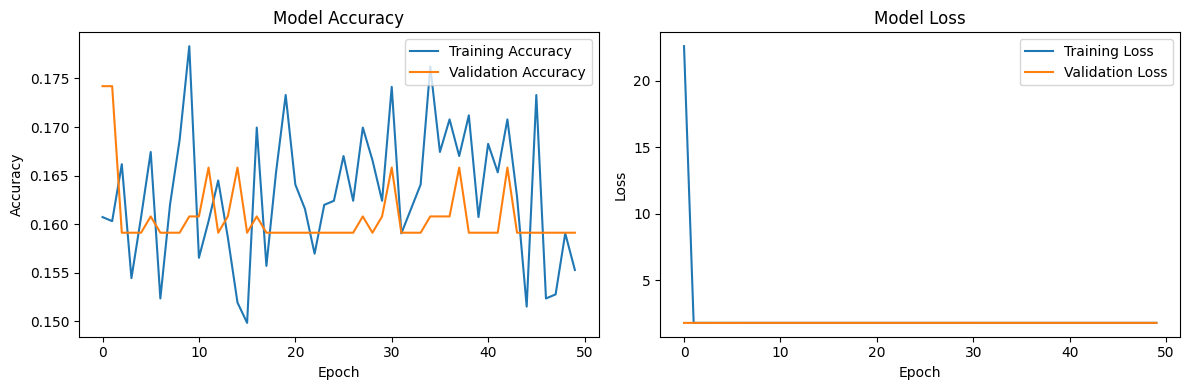

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 13 Sauvegarde du mod√®le

In [16]:
model.save('bird_audio_classifier_v2.h5')

Epoch 1/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 206ms/step - accuracy: 0.1961 - loss: 2.7934 - val_accuracy: 0.2345 - val_loss: 2.4411
Epoch 2/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 125ms/step - accuracy: 0.2334 - loss: 2.5122 - val_accuracy: 0.2462 - val_loss: 1.7920
Epoch 3/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 120ms/step - accuracy: 0.2637 - loss: 2.3575 - val_accuracy: 0.3132 - val_loss: 1.6867
Epoch 4/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 104ms/step - accuracy: 0.2891 - loss: 2.2546 - val_accuracy: 0.3266 - val_loss: 1.8147
Epoch 5/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 113ms/step - accuracy: 0.3068 - loss: 2.1301 - val_accuracy: 0.3166 - val_loss: 1.9352
Epoch 6/50
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 124ms/step - accuracy: 0.3011 - loss: 2.1344 - val_accuracy: 0.3400 - val_l

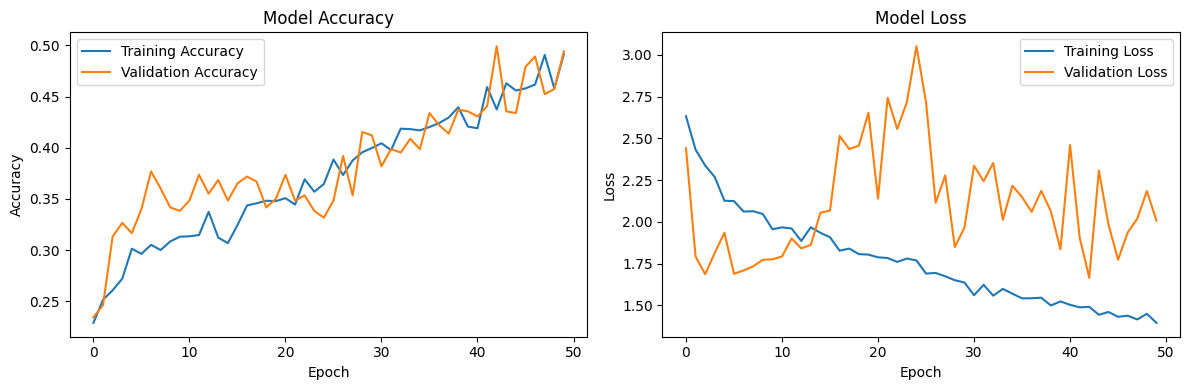

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Increased dropout rate

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),  # Add random zoom
    tf.keras.layers.RandomContrast(0.2)  # Add random contrast adjustment
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Training with early stopping and learning rate reduction
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=50,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=10,  # Increased patience
    #         restore_best_weights=True
    #     ),
    #     tf.keras.callbacks.ReduceLROnPlateau(
    #         monitor='val_loss',
    #         factor=0.5,
    #         patience=3,
    #         verbose=1
    #     )
    # ]
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 193ms/step - accuracy: 0.2056 - loss: 2.9072 - val_accuracy: 0.2278 - val_loss: 4.8830
Epoch 2/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 125ms/step - accuracy: 0.2386 - loss: 2.4674 - val_accuracy: 0.2462 - val_loss: 2.2820
Epoch 3/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 112ms/step - accuracy: 0.2944 - loss: 2.2479 - val_accuracy: 0.3015 - val_loss: 1.7682
Epoch 4/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 111ms/step - accuracy: 0.2636 - loss: 2.2304 - val_accuracy: 0.3434 - val_loss: 1.6866
Epoch 5/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 123ms/step - accuracy: 0.2764 - loss: 2.2050 - val_accuracy: 0.3618 - val_loss: 1.6743
Epoch 6/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 104ms/step - accuracy: 0.3114 - loss: 2.1543 - val_accuracy: 0.3199 - val_los

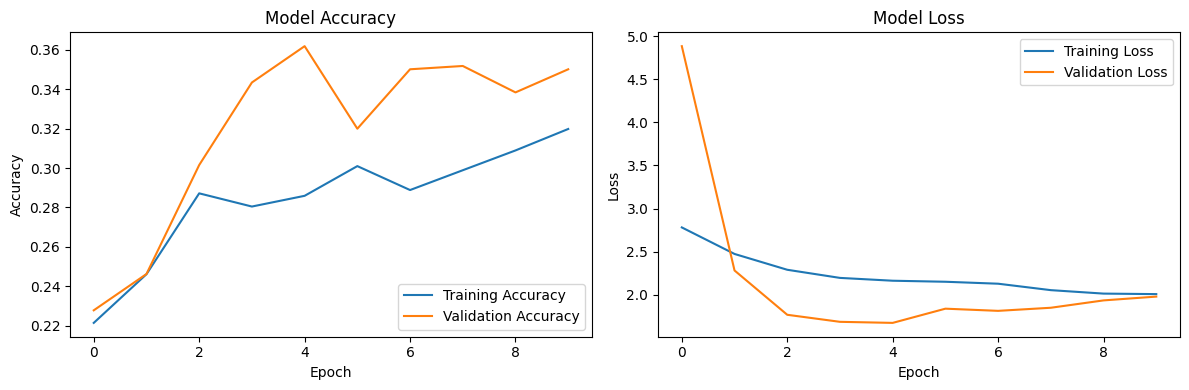

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),  # Add random zoom
    tf.keras.layers.RandomContrast(0.2)  # Add random contrast adjustment
])

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Training with early stopping and learning rate reduction
history = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_60']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 60s 197ms/step - accuracy: 0.2468 - loss: 1.7589 - val_accuracy: 0.3903 - val_loss: 1.5566
Epoch 2/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 141ms/step - accuracy: 0.4712 - loss: 1.4133 - val_accuracy: 0.5042 - val_loss: 1.3131
Epoch 3/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 135ms/step - accuracy: 0.5426 - loss: 1.2221 - val_accuracy: 0.5913 - val_loss: 1.1154
Epoch 4/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 141ms/step - accuracy: 0.5969 - loss: 1.0700 - val_accuracy: 0.5946 - val_loss: 1.0464
Epoch 5/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 141ms/step - accuracy: 0.6411 - loss: 0.9566 - val_accuracy: 0.6198 - val_loss: 1.0102
Epoch 6/10
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 138ms/step - accuracy: 0.6959 - loss: 0.8526 - val_accuracy: 0.6516 - val_loss: 0.91

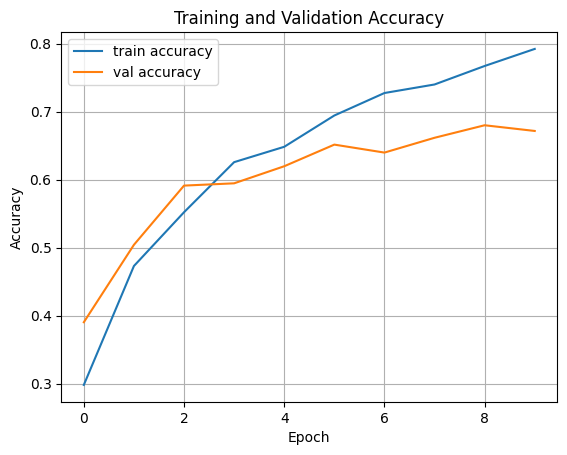

In [19]:
# üî• Utilisation d'un mod√®le pr√©-entra√Æn√© EfficientNetB0 pour la classification des spectrogrammes

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation # Import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
#from tensorflow.keras.layers.experimental import preprocessing # Import preprocessing -> No longer needed


# D√©finir les dimensions d'entr√©e
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3  # RGB

# D√©finir l'entr√©e
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Charger EfficientNetB0 sans la couche de classification finale
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Fine-tuning : d√©bloquer les couches sup√©rieures et laisser le mod√®le de base entra√Ænable
for layer in base_model.layers[-20:]:
    layer.trainable = True
base_model.trainable = True # Laisser le mod√®le de base entra√Ænable

# Augmentation des donn√©es
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"), # Use RandomFlip directly from keras.layers
    RandomRotation(0.2), # Use RandomRotation directly from keras.layers
])

# Appliquer l'augmentation des donn√©es √† l'entr√©e
x = data_augmentation(inputs)

# Passer l'entr√©e augment√©e au mod√®le de base
x = base_model(x, training=False)

# Ajouter une t√™te de classification
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Cr√©er le mod√®le final
model = Model(inputs, outputs)

# Compiler le mod√®le avec un taux d'apprentissage l√©g√®rement plus √©lev√©
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entra√Æner le mod√®le
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Afficher les courbes d'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [20]:
model.save('bird_audio_classifier_EfficientNetB0.h5')

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_552']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54s 177ms/step - accuracy: 0.2152 - loss: 2.3013 - val_accuracy: 0.2630 - val_loss: 2.1304
Epoch 2/30
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 140ms/step - accuracy: 0.3333 - loss: 2.0504 - val_accuracy: 0.4372 - val_loss: 1.8830
Epoch 3/30
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.4444 - loss: 1.8542 - val_accuracy: 0.5410 - val_loss: 1.7089
Epoch 4/30
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 138ms/step - accuracy: 0.5184 - loss: 1.6785 - val_accuracy: 0.5611 - val_loss: 1.5890
Epoch 5/30
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 140ms/step - accuracy: 0.5797 - loss: 1.5661 - val_accuracy: 0.6097 - val_loss: 1.4914
Epoch 6/30
75/75 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.6176 - loss: 1.4583 - val_accuracy: 0.6365 - val_loss: 1.40

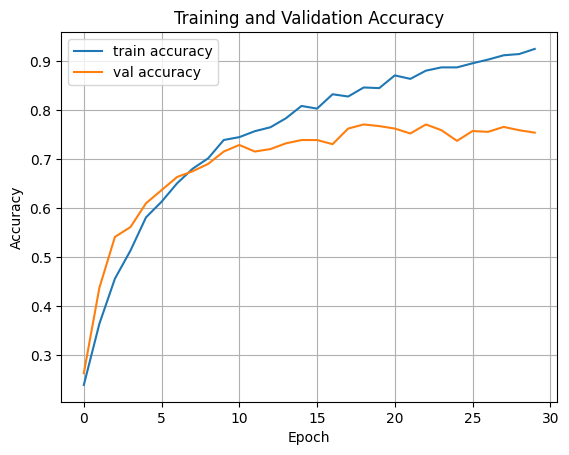

In [23]:
# üî• Utilisation d'un mod√®le pr√©-entra√Æn√© EfficientNetB0 pour la classification des spectrogrammes

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, RandomFlip, RandomRotation # Import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
#from tensorflow.keras.layers.experimental import preprocessing # Import preprocessing -> No longer needed


# D√©finir les dimensions d'entr√©e
IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3  # RGB

# D√©finir l'entr√©e
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Charger EfficientNetB0 sans la couche de classification finale
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# Fine-tuning : d√©bloquer les couches sup√©rieures et laisser le mod√®le de base entra√Ænable
for layer in base_model.layers[-100:]:
    layer.trainable = True
base_model.trainable = True # Laisser le mod√®le de base entra√Ænable

# Augmentation des donn√©es
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"), # Use RandomFlip directly from keras.layers
    RandomRotation(0.2), # Use RandomRotation directly from keras.layers
])

# Appliquer l'augmentation des donn√©es √† l'entr√©e
x = data_augmentation(inputs)

# Passer l'entr√©e augment√©e au mod√®le de base
x = base_model(x, training=False)

# Ajouter une t√™te de classification
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# outputs = Dense(num_classes, activation='softmax')(x)

# Ajouter Dropout et Weight Decay (exemple)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)  # Weight Decay
x = Dropout(0.5)(x)  # Dropout
outputs = Dense(num_classes, activation='softmax')(x)


# Cr√©er le mod√®le final
model = Model(inputs, outputs)

# Compiler le mod√®le avec un scheduler de taux d'apprentissage
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# Compiler le mod√®le avec un taux d'apprentissage l√©g√®rement plus √©lev√©
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entra√Æner le mod√®le
history = model.fit(train_ds, validation_data=val_ds, epochs=30)


# Afficher les courbes d'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [24]:
model.save('bird_audio_classifier_EfficientNetB0.h5')